# OpenFE Showcase: Relative Binding Free Energy of T4 Lysozyme


## 0. Setup for Google Colab

If you are running this example in Google Colab, run the following cells to setup the environment. If you are running this notebook locally, skip down to `1. Overview`

In [1]:
# NBVAL_SKIP
# Only run this cell if on google colab
import os
if "COLAB_RELEASE_TAG" in os.environ:
    !pip install -q condacolab
    import condacolab
    condacolab.install_from_url("https://github.com/OpenFreeEnergy/ExampleNotebooks/releases/download/april-2023/OpenFEforge-June-2023-Linux-x86_64.sh")

In [2]:
# NBVAL_SKIP
# Only run this cell if on google colab
import os
if "COLAB_RELEASE_TAG" in os.environ:
    import condacolab
    import locale
    locale.getpreferredencoding = lambda: "UTF-8"
    !mkdir inputs && cd inputs && openfe fetch rbfe-showcase
    for _ in range(3):
      # Sometimes we have to re-run the check
      try:
        condacolab.check()
      except:
        pass
      else:
        break

## 1. Overview

In this example we look how one could set up a network of transformations using
the OpenFE toolkit for small chemical modifications of ligands binding to tyrosine kinase 2 (TYK2).

This notebook demonstrates the current capabilities of the OpenFE toolkit. Here
we specifically look at how relative binding free energy calculations can be
carried out using the OpenMM MD engine in combination with the OpenFE toolset.
This notebook will be continually updated as OpenFE introduces new features.

For convenience, a prepared (capped and protonated) PDB structure of the
TYK2 protein is provided under `inputs/tyk2_protein.pdb`.

### Alchemical transformations of TYK2 ligands

Here we explore how OpenFE can be used
to build a simple star map network for planned alchemical substitutions of the TYK2 ligands.

Ten pre-aligned compounds are available under
`inputs/tyk2_ligands.sdf`. These are shown in the cell below.

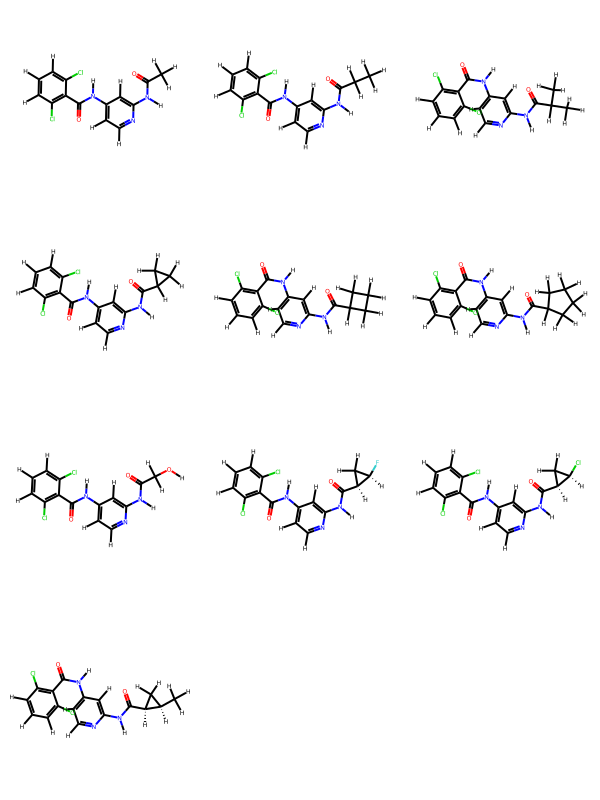

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

# Extract the contents of the sdf file and visualise it
ligands_rdmol = [mol for mol in
                 Chem.SDMolSupplier('inputs/tyk2_ligands.sdf', removeHs=False)]

for ligand in ligands_rdmol:
    AllChem.Compute2DCoords(ligand)

Chem.Draw.MolsToGridImage(ligands_rdmol)

Ultimately we will limit the RBFEs done in this notebook to the transformation
of benzene to phenol, as similarly done in the [AMBER free energy tutorial](https://ambermd.org/tutorials/advanced/tutorial9/index.html#home). Previous work has
shown that phenol does not bind to T4-Lysozyme L99A, so we expect that the RBFE
will capture the positive change in the free energy.

### The plan

Here is what we will achieve in this notebook and what software toolchains are
used along the way.

| **Actions**                    | **Software**                                                |
|:------------------------------:|:-----------------------------------------------------------:|
| Create OpenFE Molecules        | OpenFE tk, RDKit                                            |
| Create Radial Network          | OpenFE tk, Lomap, Networkx                                  |
| Visualise Network              | OpenFE tk, NetworkX, RDKit, Matplotlib                      |
| Create ligand topologies       | OpenFE tk interface - OpenFF tk                             |
| Create hybrid OpenMM topology  | OpenFE tk interface - OpenMMTools (eventually - ex Perses)  |
| Create Lambda Protocol         | OpenFE tk interface - OpenMMTools (eventually - ex Perses)  |
| Setup and run RBFE calculation | OpenFE tk interface - OpenMM + OpenMMTools                  |
| Analysis RBFE calculation      | OpenFE tk interface - PyMBAR + OpenMMTools                  |


A complete overview of the setup and simulation process starting from initial SDF and PDB files can be found [in this diagram](./assets/RBFE_workflow.drawio.pdf).

## 2. Creating a transformation network

### Creating OpenFE SmallMoleculeComponents

In order to keep track of the various inputs being passed through the OpenFE
toolkit, OpenFE implements a set of Components which define the proteins,
small molecules and solvent components which a system may contain. Here we
use the [SmallMoleculeComponent](https://github.com/OpenFreeEnergy/gufe/blob/main/gufe/smallmoleculecomponent.py)
which takes in either [RDKit molecules](https://www.rdkit.org/docs/source/rdkit.Chem.rdmolfiles.html)
or [OpenFF molecules](https://open-forcefield-toolkit.readthedocs.io/en/0.9.2/api/generated/openff.toolkit.topology.Molecule.html).

In the backend, OpenFE treats the RDKit molecules as the central representation
of the ligands, and uses the OpenFF toolkit to convert between objects from
various toolchains (for example OpenEye's OEMol).

Here we demonstrate how to load the ligands from `inputs/ligands.sdf` into a
list of OpenFE SmallMoleculeComponents for further processing.

In [2]:
from openfe import SmallMoleculeComponent

# Create and SDF supplier
# Extract the contents of the sdf file and visualise it
ligands_sdf = Chem.SDMolSupplier('inputs/tyk2_ligands.sdf', removeHs=False)

# Now pass these to form a list of Molecules
ligand_mols = [SmallMoleculeComponent(sdf) for sdf in ligands_sdf]

OpenFE SmallMoleculeComponents have some useful built in attributes and methods.

For example the molecule's name (as defined by the SDF file) can be accessed

In [3]:
print("name: ", ligand_mols[0].name)

name:  lig_ejm_31


SmallMoleculeComponents also have a means of serialising through their `to_dict()` method.

In [4]:
ligand_mols[0].to_dict()

{'atoms': [(1, 0, 0, False, 0, 0, {}),
  (6, 0, 0, True, 0, 0, {}),
  (6, 0, 0, True, 0, 0, {}),
  (6, 0, 0, True, 0, 0, {}),
  (6, 0, 0, True, 0, 0, {}),
  (6, 0, 0, True, 0, 0, {}),
  (6, 0, 0, True, 0, 0, {}),
  (1, 0, 0, False, 0, 0, {}),
  (17, 0, 0, False, 0, 0, {}),
  (6, 0, 0, False, 0, 0, {}),
  (8, 0, 0, False, 0, 0, {}),
  (7, 0, 0, False, 0, 0, {}),
  (1, 0, 0, False, 0, 0, {}),
  (6, 0, 0, True, 0, 0, {}),
  (6, 0, 0, True, 0, 0, {}),
  (6, 0, 0, True, 0, 0, {}),
  (7, 0, 0, True, 0, 0, {}),
  (6, 0, 0, True, 0, 0, {}),
  (6, 0, 0, True, 0, 0, {}),
  (1, 0, 0, False, 0, 0, {}),
  (7, 0, 0, False, 0, 0, {}),
  (1, 0, 0, False, 0, 0, {}),
  (6, 0, 0, False, 0, 0, {}),
  (8, 0, 0, False, 0, 0, {}),
  (6, 0, 0, False, 0, 0, {}),
  (1, 0, 0, False, 0, 0, {}),
  (1, 0, 0, False, 0, 0, {}),
  (1, 0, 0, False, 0, 0, {}),
  (1, 0, 0, False, 0, 0, {}),
  (1, 0, 0, False, 0, 0, {}),
  (17, 0, 0, False, 0, 0, {}),
  (1, 0, 0, False, 0, 0, {})],
 'bonds': [(0, 1, 1, 0, {}),
  (1, 6, 12

As previously stated SmallMoleculeComponents also use the OpenFF backend to allow conversion between different object types. For example it's possible to obtain an openff Molecule:

In [5]:
type(ligand_mols[0].to_openff())

openff.toolkit.topology.molecule.Molecule

### Creating a network

From these SmallMoleculeComponents we can quickly create a star map network which centers
around the first ligand in our sdf file (benzene) using
`openfe.setup.ligand_network_planning.generate_radial_network`.

Here we use Lomap (via the OpenFE interface LomapAtomMapper) to define the atom mappings between the various ligands and the central benzene structure. Whilst
we use the defaults here, please note that the various supported arguments of
Lomap can be passed to LomapAtomMapper.

Note: LomapAtomMapper is one of three currently implemented Mappers in OpenFE,
the other two being the Kartograf atom mapper and the rjmc mapper from Perses. Long term, users will be able to pass serveral
mappers and atom mapping scoring methods on network generation.

In [6]:
# Create network from the two molecules
from openfe.setup.ligand_network_planning import generate_radial_network
from openfe.setup import LomapAtomMapper

network = generate_radial_network(ligands=ligand_mols[1:],
                                  central_ligand=ligand_mols[0],
                                  mappers=[LomapAtomMapper(threed=True, element_change=False),])

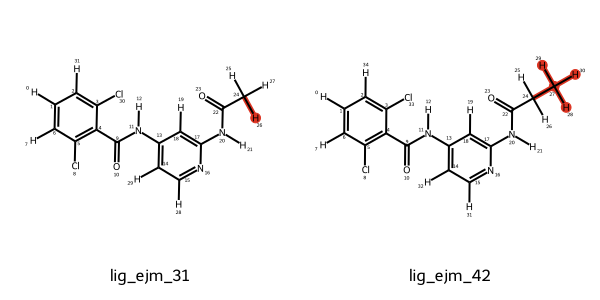

In [7]:
edges = [edge for edge in network.edges]
edge = edges[0]
edge

This network contains a set of 6 edges centered around the benzene molecule
which define the various atom mappings between the the transformation pairs.


Edges along the network can be accessed to recover the invidual molecules
involved in that given alchemical tranformation, and the atom mapping between
the two ligands.

**Note: as can be seen in the example below, transformations are defined within OpenFE as going from componentA to componentB**

In [8]:
transform_edges = [edge for edge in network.edges]
print("molecule A smiles: ", transform_edges[0].componentA.smiles)
print("molecule B smiles: ", transform_edges[0].componentB.smiles)
print("map between molecule A and B: ", transform_edges[0].componentA_to_componentB)

molecule A smiles:  CC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1
molecule B smiles:  CCC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1
map between molecule A and B:  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 26, 27: 25, 28: 31, 29: 32, 30: 33, 31: 34}


We can also visualise the atom mappings by invoking the individual OpenFE
AtomMapping objects directly.

Here we show how to draw two mappings for benzene -> phenol and benzene -> anisole.

Unique atoms between each mapping are shown in red, and atoms which are mapped
but undergo element changes are shown in blue. Bonds which either involve atoms that are unique or undergo element changes are highlighted in red.

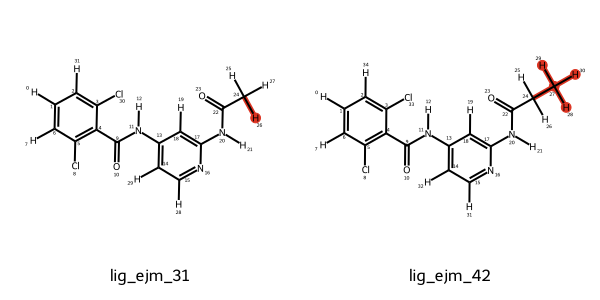

In [12]:
# Looking at the mapping of an edge
edge = [edge for edge in network.edges if edge.componentA.name == "lig_ejm_31"][0]
edge

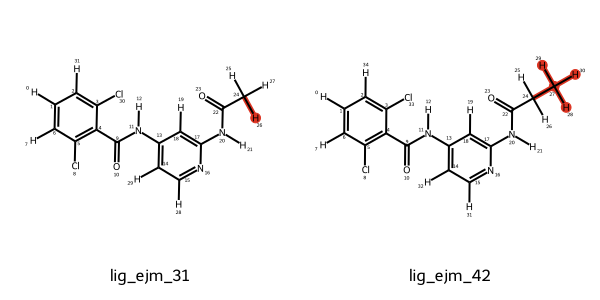

In [13]:
from IPython.display import Image

# mappings can also be saved to file if required
edge = [edge for edge in network.edges if edge.componentA.name == "lig_ejm_31"][0]
edge.draw_to_file('tyk2_edge.png')

# load it back for visualisation
Image("tyk2_edge.png")

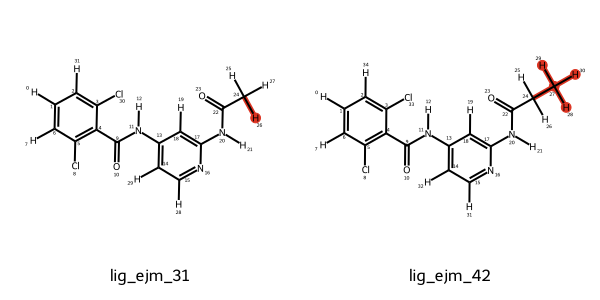

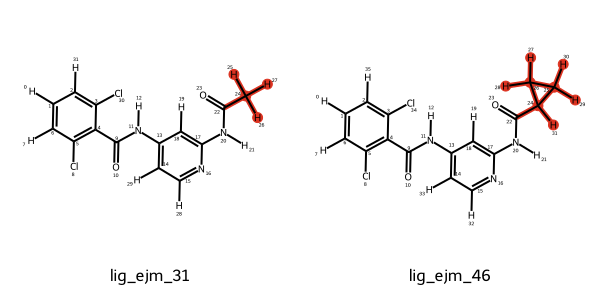

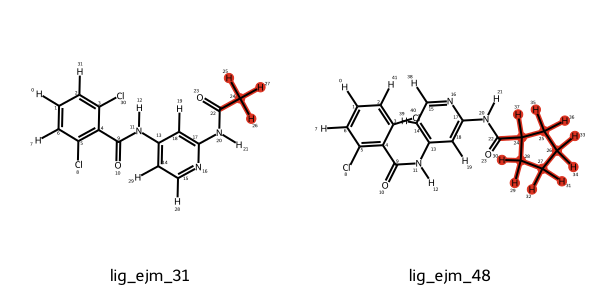

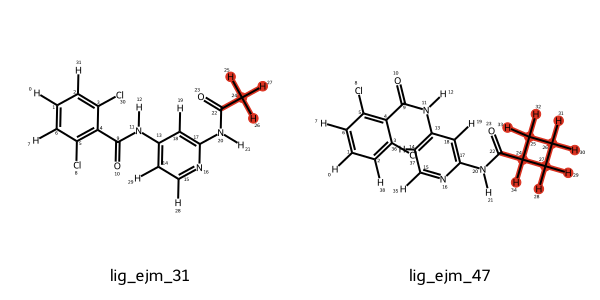

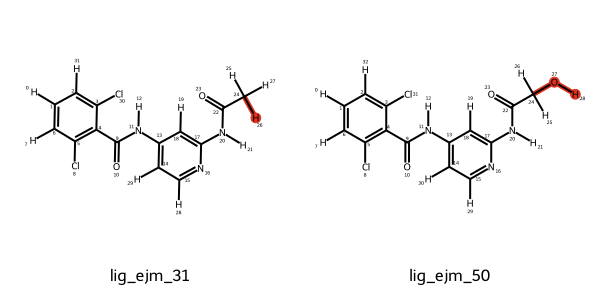

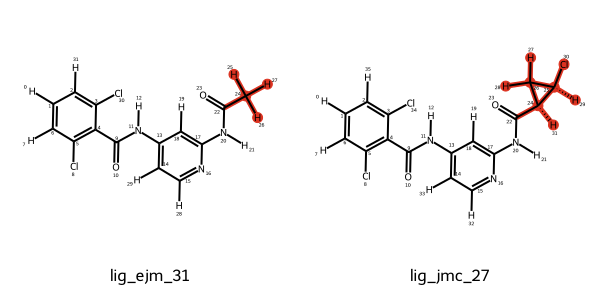

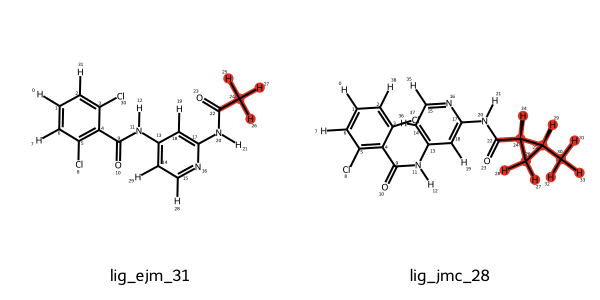

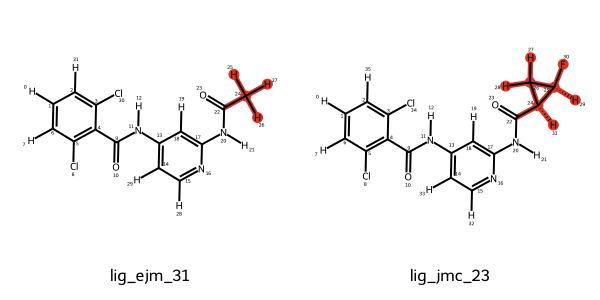

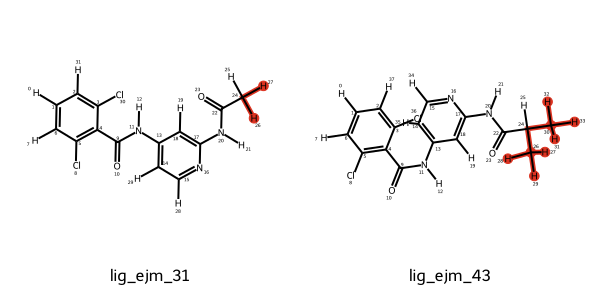

In [14]:
# Display all the atom mappings
edges = [edge for edge in network.edges]
for edge in edges:
    display(edge)

### Storing the network

Created networks can easily be converted to (and also loaded from) as a GraphML representation.

This can allow users of OpenFE to store the network to disk for later use.

In [15]:
# Convert to graphml
with open("network_store.graphml", "w") as writer:
    writer.write(network.to_graphml())

In [16]:
from openfe.setup import LigandNetwork

# load a new network from this graphml representation
with open('network_store.graphml', 'r') as file:
    network_data = file.read()

new_network = LigandNetwork.from_graphml(network_data)

In [17]:
edges = [edge for edge in new_network.edges]
print(f"edge 0 molecule 1: {edges[0].componentA.name}")
print(f"edge 0 molecule 2: {edges[0].componentB.name}")
print(f"edge 0 mapping: {edges[0].componentA_to_componentB}")

edge 0 molecule 1: lig_ejm_31
edge 0 molecule 2: lig_ejm_42
edge 0 mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 26, 27: 25, 28: 31, 29: 32, 30: 33, 31: 34}


### The OpenFE CLI

The OpenFE toolkit also has a command line interface which we plan to add several convenience methods to.

For now functionality is limited to atom mapping, but it will be expanded upon as the project grows.

In [18]:
# Call help on the OpenFE CLI
!openfe --help

Usage: openfe [OPTIONS] COMMAND [ARGS]...

  This is the command line tool to provide easy access to functionality from
  the OpenFE Python library.

Options:
  --version   Show the version and exit.
  --log PATH  logging configuration file
  -h, --help  Show this message and exit.

Network Planning Commands:
  plan-rhfe-network    Plan a relative hydration free energy network, saved as
                       JSON files for the quickrun command.
  plan-rbfe-network    Plan a relative binding free energy network, saved as
                       JSON files for the quickrun command.
  view-ligand-network  Visualize a ligand network

Quickrun Executor Commands:
  gather    Gather result jsons for network of RFE results into a TSV file
  quickrun  Run a given transformation, saved as a JSON file

Miscellaneous Commands:
  fetch  Fetch tutorial or other resource.
  test   Run the OpenFE test suite


In [19]:
### Fully remove this???
# Get an atom mapping using the CLI

!openfe atommapping --mapper LomapAtomMapper --mol inputs/benzene.sdf --mol inputs/styrene.sdf

{0: 5, 1: 6, 2: 7, 3: 8, 4: 9, 5: 10, 6: 11, 7: 12, 8: 13, 9: 14, 10: 4, 11: 15}


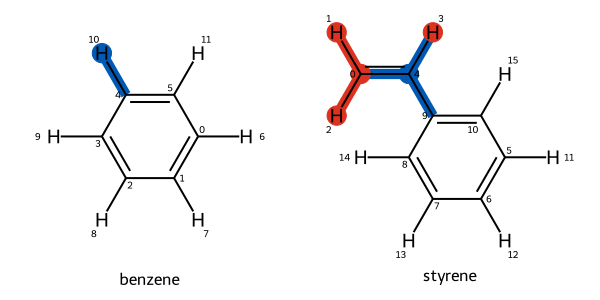

In [21]:
### Fully remove this????
# We can also directly visualise the mapping
!openfe atommapping --mapper LomapAtomMapper --mol inputs/benzene.sdf --mol inputs/styrene.sdf --output test.png

Image('test.png')

## 3. Running a Relative Ligand Binding Free Energy Calculation

Now that we have a set of atom mappings defined, we know which atoms should
undergo alchemical transformations to capture the free energy cost of
transforming from one ligand to another.

To simulate this transformation we use the equilibrium RBFE protocol
implemented in OpenFE. This uses OpenMM to run a Perses-like relative
ligand binding free energy calculation using a single topology approach.

To achieve this simulation, the following steps need to happen:

1. Create OpenMM systems of both end states


2. Create a hybrid topology based on these defined endstates


3. Set an appropriate Lambda schedule


4. Set a MultiState reporter to write out appropriate coordinates and energies


5. Create an OpenMM sampler (in this case we will be using a replica exchange sampler)


6. Carry out the necessary simulation steps (minimization, equilibration, and production)


The `RelativeHybridTopologyProtocol` class in `openfe.protocols.openmm_rfe`
implements a means to achieve all the above with minimal intervention.

Here we work through its usage for the benzene -> phenol binding free energy
test case. As this involves both a relative binding free energy in solvent
and complex phases, the `RelativeHybridTopologyProtocol` Protocol will
be used to build two separate `ProtocolDAG` (directed-acyclic-graph) classes, one for each phase.
These `DAG`s (which contain the necessary individual simulations), are then executed to yield
the desired free energy results.

**Note: the underlying components used for the creation of OpenMM hybrid
topologies and samplers is still in flux, originating mostly from Perses.
Please consider these to be in beta.**

### Defining the ChemicalSystems

`ChemicalSystems` are OpenFE containers which define the various components
which exist in a system of interest. You can consider these to be the nodes
along an alchemical network which are connected by edges which carry out
calculations along Alchemical states to get free energies.

`ChemicalSystems` take in three different things:

1. A dictionary of the chemical components (e.g. `SmallMoleculeComponent`,
   `ProteinComponent`, `SolventComponent`) defining the system.


2. Box vectors (optional), defining the shape and size of the unit cell of the
   system.


3. An identifier name (optional), for the `ChemicalSystem`. This is used as part
   of the hash identifier of the `ChemicalSystem`, and can help distinguish between
   otherwise comparable systems.

In the case of a relative ligand binding free energy calculation for benzene -> phenol,
four `ChemicalSystems` must be defined:

1. Benzene in complex with T4 lysozyme in a box of water


2. Phenol in complex with T4 lysozyme in a box of water


3. Benzene in a box of water


4. Phenol in a box of water


Here we will be passing the previously defined `SmallMoleculeComponents` for benzene
and phenol. We will also pass a `ProteinComponent` generated from the PDB file
present under `inputs/181L_mod_capped_protonated.pdb`. Finally, instead of passing
in a specific box of water, we will define a `SolventComponent` which will contain
the necessary information for OpenMM's `Modeller` class to add water and 0.15 M NaCl
around the solute when creating the OpenMM simulation objects.

In [20]:
# First let's define the Protein and Solvent Components which we will be using
from openfe import SolventComponent, ProteinComponent
from openff.units import unit

protein = ProteinComponent.from_pdb_file('inputs/tyk2_protein.pdb')

# Note: the distance from the solute to add water is not defined here but in the
# the relevant RBFE solver method
solvent = SolventComponent(positive_ion='Na', negative_ion='Cl',
                           neutralize=True, ion_concentration=0.15*unit.molar)

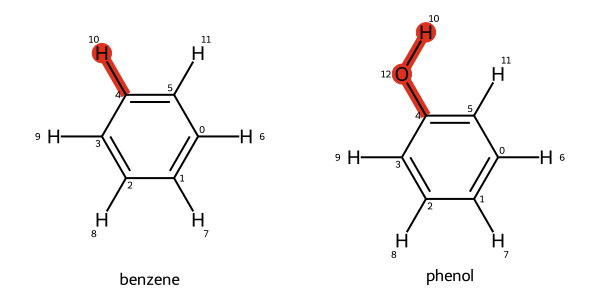

In [23]:
# Extract the relevant edge for the benzene -> phenol transform in the radial graph
benz_to_phenol = [edge for edge in network.edges if edge.componentB.name == "phenol"][0]

benz_to_phenol

In [24]:
# Let's create the four ChemicalSystems
from openfe import ChemicalSystem

benzene_complex = ChemicalSystem({'ligand': benz_to_phenol.componentA,
                                  'solvent': solvent,
                                  'protein': protein,})
benzene_solvent = ChemicalSystem({'ligand': benz_to_phenol.componentA,
                                  'solvent': solvent,})

phenol_complex = ChemicalSystem({'ligand': benz_to_phenol.componentB,
                                 'solvent': solvent,
                                 'protein': protein,})
phenol_solvent = ChemicalSystem({'ligand': benz_to_phenol.componentB,
                                 'solvent': solvent,})

### Defining the RBFE simulation settings

There are various different parameters which can be set to determine
how the RBFE simulation will take place. To allow for maximum user flexibility, these are defined as a series of settings objects which control the following::

1. `protocol_repeats`: The number of completely independent repeats of the entire sampling process.

2. `simulation_settings`: Parameters controling the simulation plan and the alchemical sampler, including the number of minimization steps, lengths of equilibration and production runs, the sampler method (e.g. Hamiltonian replica exchange, `repex`), and the time interval at which to perform an analysis of the free energies.

3. `output_settings`: Simulation output control settings, including the frequency to write a checkpoint file, the selection string for which part of the system to write coordinates for, and the paths to the trajectory and output structure storage files.

4. `alchemical_settings`: Parameters controlling the creation of the hybrid topology system. This includes various parameters ranging from softcore parameters, through to whether or not to apply an explicit charge correction for systems with net charge changes.

5. `engine_settings`: Parameters determining how the OpenMM engine will execute the simulation. This controls the compute platform which will be used to carry out the simulation.

6. `integrator_settings`: Parameters controlling the `LangevinSplittingDynamicsMove` integrator used for simulation.

7. `lambda_settings`: Lambda protocol settings, including number of lambda windows and lambda functions.

8. `forcefield_settings`: Parameters to set up the force field with OpenMM Force Fields, including the general forcefields, the small molecule forcefield, the nonbonded method, and the nonbonded cutoff.

9. `thermo_settings`: Settings for thermodynamic parameters, such as the temperature and the pressure of the system.

10. `solvation_settings`: Settings for solvating the system, including the solvent model and the solvent padding.

11. `partial_charge_settings`: Settings for assigning partial charges to small molecules, including the partial charge method (e.g. `am1bcc`) and the openff toolkit backend (e.g. `ambertools` or `openeye`).


By default these settings use the values which are considered appropriate for RBFE calculations, however these are very system dependent and may not always be suitable for every case. A judicious choice of settings is always advised.

The `RelativeHybridTopologyProtocol` class can directly populate the above set of default
settings through its `default_settings` method.

In [25]:
from openfe.protocols.openmm_rfe import RelativeHybridTopologyProtocol
from pprint import pprint

rbfe_settings = RelativeHybridTopologyProtocol.default_settings()
pprint(rbfe_settings.dict())

{'alchemical_settings': {'endstate_dispersion_correction': False,
                         'explicit_charge_correction': False,
                         'explicit_charge_correction_cutoff': <Quantity(0.8, 'nanometer')>,
                         'softcore_LJ': 'gapsys',
                         'softcore_alpha': 0.85,
                         'turn_off_core_unique_exceptions': False,
                         'use_dispersion_correction': False},
 'engine_settings': {'compute_platform': None},
 'forcefield_settings': {'constraints': 'hbonds',
                         'forcefields': ['amber/ff14SB.xml',
                                         'amber/tip3p_standard.xml',
                                         'amber/tip3p_HFE_multivalent.xml',
                                         'amber/phosaa10.xml'],
                         'hydrogen_mass': 3.0,
                         'nonbonded_cutoff': <Quantity(1.0, 'nanometer')>,
                         'nonbonded_method': 'PME',
          

In [26]:
from pprint import pp
from openff.units import unit

# Parameters can be overriden after creation
# In this case, we'll reduce the equilibration length to 0.01 * nanosecond
# and the production to 0.05 * nanosecond in order to reduce the costs of
# running this notebook (in practice values of 2 and 5 nanoseconds
# respectively would be most appropriate)

rbfe_settings.simulation_settings.equilibration_length = 10 * unit.picosecond
rbfe_settings.simulation_settings.production_length = 50 * unit.picosecond

pprint(rbfe_settings.simulation_settings.dict())

{'early_termination_target_error': <Quantity(0.0, 'kilocalorie_per_mole')>,
 'equilibration_length': <Quantity(0.01, 'nanosecond')>,
 'minimization_steps': 5000,
 'n_replicas': 11,
 'production_length': <Quantity(0.05, 'nanosecond')>,
 'real_time_analysis_interval': <Quantity(250, 'picosecond')>,
 'real_time_analysis_minimum_time': <Quantity(500, 'picosecond')>,
 'sampler_method': 'repex',
 'sams_flatness_criteria': 'logZ-flatness',
 'sams_gamma0': 1.0,
 'time_per_iteration': <Quantity(1, 'picosecond')>}


### Creating the RelativeLigandTransform Protocol

With the Settings inspected and adjusted, we can provide these to the Protocol.
This Protocol defines the procedure to estimate a free energy difference between two chemical systems,
with the details of the two end states yet to be defined.

In [27]:
# Create RBFE Protocol class
rbfe_transform = RelativeHybridTopologyProtocol(
    settings=rbfe_settings
)

### Creating the Protocol DAGs

With the **method** we will be applying (the `Protocol`) defined, we can move onto applying to the alchemical transformation of interest.

The `Protocol.create()` method requires as input:
- the two `ChemicalSystem` objects defining either end of the alchemical transformation
- a mapping between the two systems, as a dict

This creates a directed-acyclic-graph (DAG) of computational tasks necessary for creating an estimate of the free energy difference between the two chemical systems.

As previously detailed, we create two sets of simulations, defining
both the complex and solvent transformations.

In [28]:
print(benz_to_phenol)

LigandAtomMapping(componentA=SmallMoleculeComponent(name=benzene), componentB=SmallMoleculeComponent(name=phenol), componentA_to_componentB={0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 11: 11}, annotations={})


In [29]:
complex_dag = rbfe_transform.create(
    stateA=benzene_complex, stateB=phenol_complex,
    mapping=benz_to_phenol,
)

solvent_dag = rbfe_transform.create(
    stateA=benzene_solvent, stateB=phenol_solvent,
    mapping=benz_to_phenol,
)

The individual pieces of computational work are called `Unit`s.  In this particular Protocol, the Units defined are three independent repeats of the alchemical transformation.

For other Protocols, for example non-equilibrium sampling routines, there might be dependencies between the tasks.

In [30]:
list(complex_dag.protocol_units)

[RelativeHybridTopologyProtocolUnit(benzene to phenol repeat 2 generation 0),
 RelativeHybridTopologyProtocolUnit(benzene to phenol repeat 1 generation 0),
 RelativeHybridTopologyProtocolUnit(benzene to phenol repeat 0 generation 0)]

### Simulating the RelativeLigandTransforms

Individual Units can then be executed by calling the `.execute()` method.

In the first instance we do a dry-run (which does everything but
starting the simulation) to make sure that the
hybrid openmm system can be constructed without any issues.
Note: A successful call to `.run()` will return an empty Dictionary.

In [31]:
# complex dry-run
complex_unit = list(complex_dag.protocol_units)[0]

complex_unit.run(dry=True, verbose=True)

INFO:	Preparing the hybrid topology simulation
INFO:	Parameterizing molecules
INFO:	Requested to generate parameters for residue <Residue 0 (UNK) of chain 0>
INFO:	Requested to generate parameters for residue <Residue 0 (UNK) of chain 0>
INFO:	Creating hybrid system
INFO:	Setting force field terms
INFO:	Adding forces
INFO:	Hybrid system created
/home/hannah/mambaforge/envs/openfe_dev/lib/python3.11/site-packages/mdtraj/core/topology.py:91: UserWarning: atom_indices are not monotonically increasing
  warnings.warn('atom_indices are not monotonically increasing')
INFO:	Creating and setting up the sampler


Please cite the following:

        Friedrichs MS, Eastman P, Vaidyanathan V, Houston M, LeGrand S, Beberg AL, Ensign DL, Bruns CM, and Pande VS. Accelerating molecular dynamic simulations on graphics processing unit. J. Comput. Chem. 30:864, 2009. DOI: 10.1002/jcc.21209
        Eastman P and Pande VS. OpenMM: A hardware-independent framework for molecular simulations. Comput. Sci. Eng. 12:34, 2010. DOI: 10.1109/MCSE.2010.27
        Eastman P and Pande VS. Efficient nonbonded interactions for molecular dynamics on a graphics processing unit. J. Comput. Chem. 31:1268, 2010. DOI: 10.1002/jcc.21413
        Eastman P and Pande VS. Constant constraint matrix approximation: A robust, parallelizable constraint method for molecular simulations. J. Chem. Theor. Comput. 6:434, 2010. DOI: 10.1021/ct900463w
        Chodera JD and Shirts MR. Replica exchange and expanded ensemble simulations as Gibbs multistate: Simple improvements for enhanced mixing. J. Chem. Phys., 135:194110, 2011. DOI:10.1063/

{'debug': {'sampler': <instance of HybridRepexSampler>}}

In [32]:
# solvent dry-run
solvent_unit = list(solvent_dag.protocol_units)[0]

solvent_unit.run(dry=True, verbose=True)

INFO:	Preparing the hybrid topology simulation
INFO:	Parameterizing molecules
INFO:	Requested to generate parameters for residue <Residue 0 (UNK) of chain 0>
INFO:	Requested to generate parameters for residue <Residue 0 (UNK) of chain 0>
INFO:	Creating hybrid system
INFO:	Setting force field terms
INFO:	Adding forces
INFO:	Hybrid system created
/home/hannah/mambaforge/envs/openfe_dev/lib/python3.11/site-packages/mdtraj/core/topology.py:91: UserWarning: atom_indices are not monotonically increasing
  warnings.warn('atom_indices are not monotonically increasing')
INFO:	Creating and setting up the sampler


Please cite the following:

        Friedrichs MS, Eastman P, Vaidyanathan V, Houston M, LeGrand S, Beberg AL, Ensign DL, Bruns CM, and Pande VS. Accelerating molecular dynamic simulations on graphics processing unit. J. Comput. Chem. 30:864, 2009. DOI: 10.1002/jcc.21209
        Eastman P and Pande VS. OpenMM: A hardware-independent framework for molecular simulations. Comput. Sci. Eng. 12:34, 2010. DOI: 10.1109/MCSE.2010.27
        Eastman P and Pande VS. Efficient nonbonded interactions for molecular dynamics on a graphics processing unit. J. Comput. Chem. 31:1268, 2010. DOI: 10.1002/jcc.21413
        Eastman P and Pande VS. Constant constraint matrix approximation: A robust, parallelizable constraint method for molecular simulations. J. Chem. Theor. Comput. 6:434, 2010. DOI: 10.1021/ct900463w
        Chodera JD and Shirts MR. Replica exchange and expanded ensemble simulations as Gibbs multistate: Simple improvements for enhanced mixing. J. Chem. Phys., 135:194110, 2011. DOI:10.1063/

{'debug': {'sampler': <instance of HybridRepexSampler>}}

### Executing the simulations.

The complex and solvent DAGs each contain many invdividual jobs. For convenience we can execute them sequentially in this notebook using the `gufe.protocols.execute` function.

In a more realistic (expansive) situation we would farm off the individual jobs to a HPC cluster or cloud compute service so they could be executed in parallel.

**Note: we use the `shared_basedir` and `scratch_basedir` argument of `execute_DAG` in order to set the directory where the simulation files are written to**

In [33]:
from gufe.protocols import execute_DAG
import pathlib

In [35]:
# Finally we can run the simulations
complex_path = pathlib.Path('./complex')
complex_path.mkdir()

# First the complex transformation
complex_dag_results = execute_DAG(complex_dag, scratch_basedir=complex_path, shared_basedir=complex_path)

INFO:	SYSTEM CONFIG DETAILS:
INFO:	hostname: 'beast'
INFO:	GPU: uuid='GPU-7ca18861-0aa7-302a-b413-9a48a3479dde' NVIDIA GeForce RTX 4070 Ti mode=Default
INFO:	Memory used: 3.1G (6.2%)
INFO:	complex/scratch_RelativeHybridTopologyProtocolUnit-021ba9e75a724ff6b506122cbb3e91d5_attempt_0: 4% full (837.5G free)
INFO:	Preparing the hybrid topology simulation
INFO:	Parameterizing molecules
INFO:	Requested to generate parameters for residue <Residue 0 (UNK) of chain 0>
INFO:	Generating a residue template for [H][c]1[c]([H])[c]([H])[c]([H])[c]([H])[c]1[H] using openff-2.0.0
INFO:	Requested to generate parameters for residue <Residue 0 (UNK) of chain 0>
INFO:	Generating a residue template for [H][O][c]1[c]([H])[c]([H])[c]([H])[c]([H])[c]1[H] using openff-2.0.0
INFO:	Creating hybrid system
INFO:	Setting force field terms
INFO:	Adding forces
INFO:	Hybrid system created
/home/hannah/mambaforge/envs/openfe_dev/lib/python3.11/site-packages/mdtraj/core/topology.py:91: UserWarning: atom_indices are not m

Please cite the following:

        Friedrichs MS, Eastman P, Vaidyanathan V, Houston M, LeGrand S, Beberg AL, Ensign DL, Bruns CM, and Pande VS. Accelerating molecular dynamic simulations on graphics processing unit. J. Comput. Chem. 30:864, 2009. DOI: 10.1002/jcc.21209
        Eastman P and Pande VS. OpenMM: A hardware-independent framework for molecular simulations. Comput. Sci. Eng. 12:34, 2010. DOI: 10.1109/MCSE.2010.27
        Eastman P and Pande VS. Efficient nonbonded interactions for molecular dynamics on a graphics processing unit. J. Comput. Chem. 31:1268, 2010. DOI: 10.1002/jcc.21413
        Eastman P and Pande VS. Constant constraint matrix approximation: A robust, parallelizable constraint method for molecular simulations. J. Chem. Theor. Comput. 6:434, 2010. DOI: 10.1021/ct900463w
        Chodera JD and Shirts MR. Replica exchange and expanded ensemble simulations as Gibbs multistate: Simple improvements for enhanced mixing. J. Chem. Phys., 135:194110, 2011. DOI:10.1063/

INFO:	Running minimization
INFO:	Running equilibration phase
INFO:	Equilibration iteration 1/10
INFO:	Iteration took 2.050s.
INFO:	Estimated completion (of equilibration only) in 0:00:18.450695, at Fri Feb 23 14:38:37 2024 (consuming total wall clock time 0:00:20.500772).
INFO:	Equilibration iteration 2/10
INFO:	Iteration took 1.315s.
INFO:	Estimated completion (of equilibration only) in 0:00:13.462997, at Fri Feb 23 14:38:33 2024 (consuming total wall clock time 0:00:16.828747).
INFO:	Equilibration iteration 3/10
INFO:	Iteration took 1.321s.
INFO:	Estimated completion (of equilibration only) in 0:00:10.937745, at Fri Feb 23 14:38:32 2024 (consuming total wall clock time 0:00:15.625350).
INFO:	Equilibration iteration 4/10
INFO:	Iteration took 1.324s.
INFO:	Estimated completion (of equilibration only) in 0:00:09.018557, at Fri Feb 23 14:38:31 2024 (consuming total wall clock time 0:00:15.030928).
INFO:	Equilibration iteration 5/10
INFO:	Iteration took 1.330s.
INFO:	Estimated completion 

Please cite the following:

        Friedrichs MS, Eastman P, Vaidyanathan V, Houston M, LeGrand S, Beberg AL, Ensign DL, Bruns CM, and Pande VS. Accelerating molecular dynamic simulations on graphics processing unit. J. Comput. Chem. 30:864, 2009. DOI: 10.1002/jcc.21209
        Eastman P and Pande VS. OpenMM: A hardware-independent framework for molecular simulations. Comput. Sci. Eng. 12:34, 2010. DOI: 10.1109/MCSE.2010.27
        Eastman P and Pande VS. Efficient nonbonded interactions for molecular dynamics on a graphics processing unit. J. Comput. Chem. 31:1268, 2010. DOI: 10.1002/jcc.21413
        Eastman P and Pande VS. Constant constraint matrix approximation: A robust, parallelizable constraint method for molecular simulations. J. Chem. Theor. Comput. 6:434, 2010. DOI: 10.1021/ct900463w
        Chodera JD and Shirts MR. Replica exchange and expanded ensemble simulations as Gibbs multistate: Simple improvements for enhanced mixing. J. Chem. Phys., 135:194110, 2011. DOI:10.1063/

INFO:	Running minimization
INFO:	Running equilibration phase
INFO:	Equilibration iteration 1/10
INFO:	Iteration took 1.709s.
INFO:	Estimated completion (of equilibration only) in 0:00:15.384760, at Fri Feb 23 14:42:11 2024 (consuming total wall clock time 0:00:17.094178).
INFO:	Equilibration iteration 2/10
INFO:	Iteration took 1.317s.
INFO:	Estimated completion (of equilibration only) in 0:00:12.109181, at Fri Feb 23 14:42:09 2024 (consuming total wall clock time 0:00:15.136477).
INFO:	Equilibration iteration 3/10
INFO:	Iteration took 1.319s.
INFO:	Estimated completion (of equilibration only) in 0:00:10.142573, at Fri Feb 23 14:42:09 2024 (consuming total wall clock time 0:00:14.489390).
INFO:	Equilibration iteration 4/10
INFO:	Iteration took 1.326s.
INFO:	Estimated completion (of equilibration only) in 0:00:08.510132, at Fri Feb 23 14:42:09 2024 (consuming total wall clock time 0:00:14.183554).
INFO:	Equilibration iteration 5/10
INFO:	Iteration took 1.327s.
INFO:	Estimated completion 

Please cite the following:

        Friedrichs MS, Eastman P, Vaidyanathan V, Houston M, LeGrand S, Beberg AL, Ensign DL, Bruns CM, and Pande VS. Accelerating molecular dynamic simulations on graphics processing unit. J. Comput. Chem. 30:864, 2009. DOI: 10.1002/jcc.21209
        Eastman P and Pande VS. OpenMM: A hardware-independent framework for molecular simulations. Comput. Sci. Eng. 12:34, 2010. DOI: 10.1109/MCSE.2010.27
        Eastman P and Pande VS. Efficient nonbonded interactions for molecular dynamics on a graphics processing unit. J. Comput. Chem. 31:1268, 2010. DOI: 10.1002/jcc.21413
        Eastman P and Pande VS. Constant constraint matrix approximation: A robust, parallelizable constraint method for molecular simulations. J. Chem. Theor. Comput. 6:434, 2010. DOI: 10.1021/ct900463w
        Chodera JD and Shirts MR. Replica exchange and expanded ensemble simulations as Gibbs multistate: Simple improvements for enhanced mixing. J. Chem. Phys., 135:194110, 2011. DOI:10.1063/

INFO:	Running minimization
INFO:	Running equilibration phase
INFO:	Equilibration iteration 1/10
INFO:	Iteration took 1.687s.
INFO:	Estimated completion (of equilibration only) in 0:00:15.186863, at Fri Feb 23 14:45:41 2024 (consuming total wall clock time 0:00:16.874292).
INFO:	Equilibration iteration 2/10
INFO:	Iteration took 1.321s.
INFO:	Estimated completion (of equilibration only) in 0:00:12.034927, at Fri Feb 23 14:45:39 2024 (consuming total wall clock time 0:00:15.043659).
INFO:	Equilibration iteration 3/10
INFO:	Iteration took 1.326s.
INFO:	Estimated completion (of equilibration only) in 0:00:10.115407, at Fri Feb 23 14:45:39 2024 (consuming total wall clock time 0:00:14.450581).
INFO:	Equilibration iteration 4/10
INFO:	Iteration took 1.330s.
INFO:	Estimated completion (of equilibration only) in 0:00:08.498115, at Fri Feb 23 14:45:38 2024 (consuming total wall clock time 0:00:14.163525).
INFO:	Equilibration iteration 5/10
INFO:	Iteration took 1.335s.
INFO:	Estimated completion 

In [36]:
# Next the solvent state transformation
solvent_path = pathlib.Path('./solvent')
solvent_path.mkdir()

solvent_dag_results = execute_DAG(solvent_dag, scratch_basedir=solvent_path, shared_basedir=solvent_path)

INFO:	SYSTEM CONFIG DETAILS:
INFO:	hostname: 'beast'
INFO:	GPU: uuid='GPU-7ca18861-0aa7-302a-b413-9a48a3479dde' NVIDIA GeForce RTX 4070 Ti mode=Default
INFO:	Memory used: 3.9G (7.5%)
INFO:	solvent/scratch_RelativeHybridTopologyProtocolUnit-e78939653dde47bb967deb840bf81cf7_attempt_0: 4% full (837.5G free)
INFO:	Preparing the hybrid topology simulation
INFO:	Parameterizing molecules
INFO:	Requested to generate parameters for residue <Residue 0 (UNK) of chain 0>
INFO:	Generating a residue template for [H][c]1[c]([H])[c]([H])[c]([H])[c]([H])[c]1[H] using openff-2.0.0
INFO:	Requested to generate parameters for residue <Residue 0 (UNK) of chain 0>
INFO:	Generating a residue template for [H][O][c]1[c]([H])[c]([H])[c]([H])[c]([H])[c]1[H] using openff-2.0.0
INFO:	Creating hybrid system
INFO:	Setting force field terms
INFO:	Adding forces
INFO:	Hybrid system created
/home/hannah/mambaforge/envs/openfe_dev/lib/python3.11/site-packages/mdtraj/core/topology.py:91: UserWarning: atom_indices are not m

Please cite the following:

        Friedrichs MS, Eastman P, Vaidyanathan V, Houston M, LeGrand S, Beberg AL, Ensign DL, Bruns CM, and Pande VS. Accelerating molecular dynamic simulations on graphics processing unit. J. Comput. Chem. 30:864, 2009. DOI: 10.1002/jcc.21209
        Eastman P and Pande VS. OpenMM: A hardware-independent framework for molecular simulations. Comput. Sci. Eng. 12:34, 2010. DOI: 10.1109/MCSE.2010.27
        Eastman P and Pande VS. Efficient nonbonded interactions for molecular dynamics on a graphics processing unit. J. Comput. Chem. 31:1268, 2010. DOI: 10.1002/jcc.21413
        Eastman P and Pande VS. Constant constraint matrix approximation: A robust, parallelizable constraint method for molecular simulations. J. Chem. Theor. Comput. 6:434, 2010. DOI: 10.1021/ct900463w
        Chodera JD and Shirts MR. Replica exchange and expanded ensemble simulations as Gibbs multistate: Simple improvements for enhanced mixing. J. Chem. Phys., 135:194110, 2011. DOI:10.1063/

INFO:	Running equilibration phase
INFO:	Equilibration iteration 1/10
INFO:	Iteration took 0.498s.
INFO:	Estimated completion (of equilibration only) in 0:00:04.484926, at Fri Feb 23 14:47:11 2024 (consuming total wall clock time 0:00:04.983251).
INFO:	Equilibration iteration 2/10
INFO:	Iteration took 0.265s.
INFO:	Estimated completion (of equilibration only) in 0:00:03.059072, at Fri Feb 23 14:47:10 2024 (consuming total wall clock time 0:00:03.823839).
INFO:	Equilibration iteration 3/10
INFO:	Iteration took 0.273s.
INFO:	Estimated completion (of equilibration only) in 0:00:02.421645, at Fri Feb 23 14:47:10 2024 (consuming total wall clock time 0:00:03.459493).
INFO:	Equilibration iteration 4/10
INFO:	Iteration took 0.271s.
INFO:	Estimated completion (of equilibration only) in 0:00:01.964701, at Fri Feb 23 14:47:09 2024 (consuming total wall clock time 0:00:03.274502).
INFO:	Equilibration iteration 5/10
INFO:	Iteration took 0.264s.
INFO:	Estimated completion (of equilibration only) in 

Please cite the following:

        Friedrichs MS, Eastman P, Vaidyanathan V, Houston M, LeGrand S, Beberg AL, Ensign DL, Bruns CM, and Pande VS. Accelerating molecular dynamic simulations on graphics processing unit. J. Comput. Chem. 30:864, 2009. DOI: 10.1002/jcc.21209
        Eastman P and Pande VS. OpenMM: A hardware-independent framework for molecular simulations. Comput. Sci. Eng. 12:34, 2010. DOI: 10.1109/MCSE.2010.27
        Eastman P and Pande VS. Efficient nonbonded interactions for molecular dynamics on a graphics processing unit. J. Comput. Chem. 31:1268, 2010. DOI: 10.1002/jcc.21413
        Eastman P and Pande VS. Constant constraint matrix approximation: A robust, parallelizable constraint method for molecular simulations. J. Chem. Theor. Comput. 6:434, 2010. DOI: 10.1021/ct900463w
        Chodera JD and Shirts MR. Replica exchange and expanded ensemble simulations as Gibbs multistate: Simple improvements for enhanced mixing. J. Chem. Phys., 135:194110, 2011. DOI:10.1063/

INFO:	Running equilibration phase
INFO:	Equilibration iteration 1/10
INFO:	Iteration took 0.322s.
INFO:	Estimated completion (of equilibration only) in 0:00:02.895239, at Fri Feb 23 14:47:35 2024 (consuming total wall clock time 0:00:03.216932).
INFO:	Equilibration iteration 2/10
INFO:	Iteration took 0.266s.
INFO:	Estimated completion (of equilibration only) in 0:00:02.354962, at Fri Feb 23 14:47:35 2024 (consuming total wall clock time 0:00:02.943703).
INFO:	Equilibration iteration 3/10
INFO:	Iteration took 0.263s.
INFO:	Estimated completion (of equilibration only) in 0:00:01.988822, at Fri Feb 23 14:47:35 2024 (consuming total wall clock time 0:00:02.841175).
INFO:	Equilibration iteration 4/10
INFO:	Iteration took 0.265s.
INFO:	Estimated completion (of equilibration only) in 0:00:01.676454, at Fri Feb 23 14:47:35 2024 (consuming total wall clock time 0:00:02.794089).
INFO:	Equilibration iteration 5/10
INFO:	Iteration took 0.264s.
INFO:	Estimated completion (of equilibration only) in 

Please cite the following:

        Friedrichs MS, Eastman P, Vaidyanathan V, Houston M, LeGrand S, Beberg AL, Ensign DL, Bruns CM, and Pande VS. Accelerating molecular dynamic simulations on graphics processing unit. J. Comput. Chem. 30:864, 2009. DOI: 10.1002/jcc.21209
        Eastman P and Pande VS. OpenMM: A hardware-independent framework for molecular simulations. Comput. Sci. Eng. 12:34, 2010. DOI: 10.1109/MCSE.2010.27
        Eastman P and Pande VS. Efficient nonbonded interactions for molecular dynamics on a graphics processing unit. J. Comput. Chem. 31:1268, 2010. DOI: 10.1002/jcc.21413
        Eastman P and Pande VS. Constant constraint matrix approximation: A robust, parallelizable constraint method for molecular simulations. J. Chem. Theor. Comput. 6:434, 2010. DOI: 10.1021/ct900463w
        Chodera JD and Shirts MR. Replica exchange and expanded ensemble simulations as Gibbs multistate: Simple improvements for enhanced mixing. J. Chem. Phys., 135:194110, 2011. DOI:10.1063/

INFO:	Running equilibration phase
INFO:	Equilibration iteration 1/10
INFO:	Iteration took 0.324s.
INFO:	Estimated completion (of equilibration only) in 0:00:02.922475, at Fri Feb 23 14:48:00 2024 (consuming total wall clock time 0:00:03.247194).
INFO:	Equilibration iteration 2/10
INFO:	Iteration took 0.267s.
INFO:	Estimated completion (of equilibration only) in 0:00:02.367698, at Fri Feb 23 14:48:00 2024 (consuming total wall clock time 0:00:02.959622).
INFO:	Equilibration iteration 3/10
INFO:	Iteration took 0.267s.
INFO:	Estimated completion (of equilibration only) in 0:00:02.005912, at Fri Feb 23 14:48:00 2024 (consuming total wall clock time 0:00:02.865589).
INFO:	Equilibration iteration 4/10
INFO:	Iteration took 0.267s.
INFO:	Estimated completion (of equilibration only) in 0:00:01.691545, at Fri Feb 23 14:48:00 2024 (consuming total wall clock time 0:00:02.819242).
INFO:	Equilibration iteration 5/10
INFO:	Iteration took 0.268s.
INFO:	Estimated completion (of equilibration only) in 

## 4. Analysis

Finally now that we've run our simulations, let's go ahead and gather the free
energies for both phases.

This can be achieved by passing the results of executing the DAGs calling the `gather()` methods of `RelativeLigandTransform`.
This takes a **list** of completed DAG results, catering for when simulations have been extended.

In [37]:
# Get the complex and solvent results
complex_results = rbfe_transform.gather([complex_dag_results])
solvent_results = rbfe_transform.gather([solvent_dag_results])

print(f"Complex dG: {complex_results.get_estimate()}, err {complex_results.get_uncertainty()}")
print(f"Solvent dG: {solvent_results.get_estimate()}, err {solvent_results.get_uncertainty()}")

Complex dG: 3.7351953809232703 kilocalorie_per_mole, err 0.10340360099413659 kilocalorie_per_mole
Solvent dG: 1.0288482528700544 kilocalorie_per_mole, err 0.23196273582173413 kilocalorie_per_mole
